# Step 3: Preprocessing Pipeline Verification

This notebook verifies the data pipeline. It ensures that:
1. The split CSV files (train/val/test) are loaded correctly.
2. The image transforms (Augmentation + Normalization) are applied as expected.
3. The data shapes match the model input requirements (Batch, Channel, Height, Width).

In [1]:
# --- Setup & Imports ---
import os
import sys
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

# Add 'src' directory to python path to import our modules
sys.path.append(os.path.abspath('../src'))
from preprocessing.preprocessing import get_transforms, MEAN, STD

print("Setup complete. Using transforms from src/preprocessing.py")

Setup complete. Using transforms from src/preprocessing.py


### 1. Define a Temporary Dataset Class
To visualize the data, we need a PyTorch Dataset class that reads the CSV files generated in the previous step.

In [2]:
class ArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get image path and label
        row = self.data.iloc[idx]
        # We need to adjust path because CSV has 'data/processed/...' but we are in 'notebooks'
        # So we go up one level (..) then follow the path
        img_path = os.path.join('..', row['image_path'])
        label = int(row['label'])
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Initialize Datasets
SPLITS_DIR = '../data/processed/splits'

# Load Train set (With Augmentation)
train_dataset = ArtDataset(
    csv_file=os.path.join(SPLITS_DIR, 'train.csv'),
    root_dir='.',
    transform=get_transforms(stage='train')
)

# Load Val set (No Augmentation)
val_dataset = ArtDataset(
    csv_file=os.path.join(SPLITS_DIR, 'val.csv'),
    root_dir='.',
    transform=get_transforms(stage='val')
)

print(f"Datasets Initialized:")
print(f"Training Samples: {len(train_dataset)}")
print(f"Validation Samples: {len(val_dataset)}")

Datasets Initialized:
Training Samples: 15866
Validation Samples: 3400


### 2. Visualize Augmented Images
We will load a batch of training images to see the effect of `RandomResizedCrop`, `Rotation`, and `Flip`.

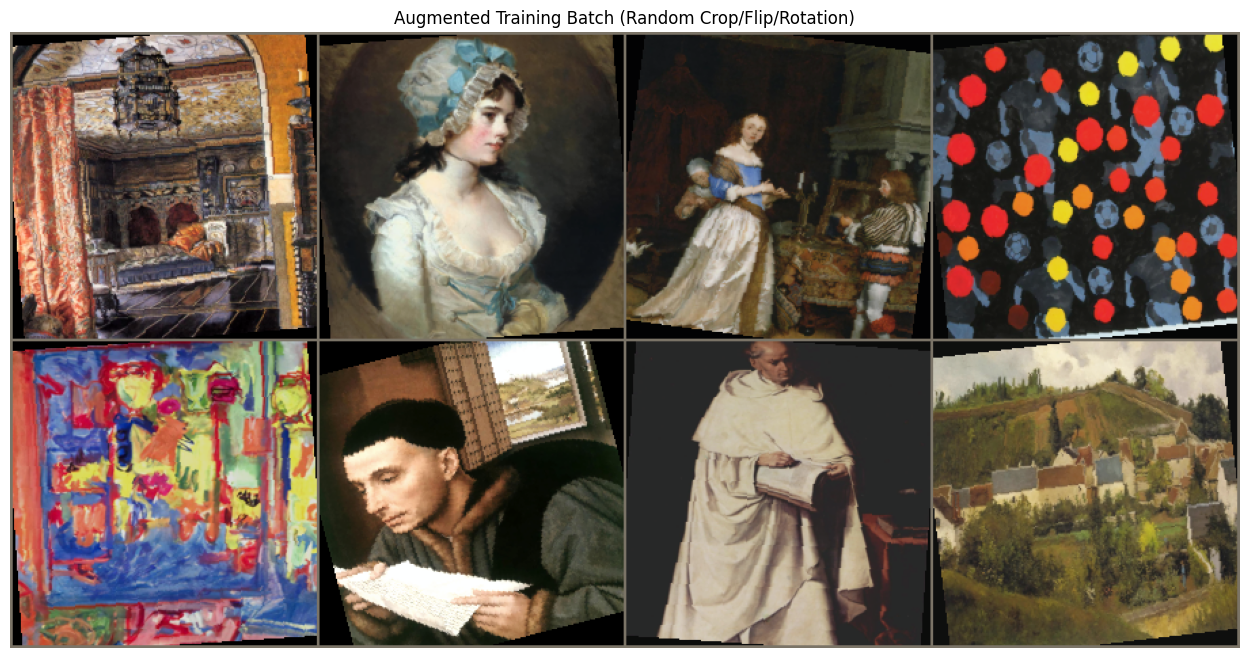

In [3]:
def imshow(tensor, title=None):
    """Helper function to un-normalize and display a tensor"""
    # Clone tensor to not change the original
    img = tensor.clone().detach().numpy().transpose((1, 2, 0))
    
    # Undo Normalization: pixel = (pixel * std) + mean
    mean = np.array(MEAN)
    std = np.array(STD)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Get a batch
images, labels = next(iter(train_loader))

# Plot
plt.figure(figsize=(16, 8))
grid_img = make_grid(images, nrow=4, padding=2)
imshow(grid_img, title="Augmented Training Batch (Random Crop/Flip/Rotation)")
plt.show()

### 3. Check Tensor Shapes
Verifying that the input dimensions match the requirement for ResNet (Batch, 3, 224, 224).

In [4]:
print("Checking Tensor Dimensions:")
print(f"Batch Shape: {images.shape}  <-- Should be (8, 3, 224, 224)")
print(f"Labels Shape: {labels.shape} <-- Should be (8)")

if images.shape[1:] == (3, 224, 224):
    print("\n✅ SUCCESS: Data is ready for the model.")
else:
    print("\n❌ ERROR: Incorrect dimensions!")

Checking Tensor Dimensions:
Batch Shape: torch.Size([8, 3, 224, 224])  <-- Should be (8, 3, 224, 224)
Labels Shape: torch.Size([8]) <-- Should be (8)

✅ SUCCESS: Data is ready for the model.
